In [38]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
import re
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import string
from wordcloud import STOPWORDS

## Exploratory data analysis


Cette EDA est faite sur les textes bruts pour identifier les patterns initiaux. Le nettoyage sera fait dans un second temps.

# Objectif :

Comprendre nos données

Développer une première stratégie de modélisation 

# Résumé : 


---

## 1. Analyse de forme

### Dimensions et structure
- **Taille du jeu de données** : `7613 lignes × 5 colonnes`
- **Variable cible** : `target` (0 = non-catastrophe, 1 = catastrophe)
- **Type de variables** :
  - **Qualitatives** : `text`, `location`, `keyword`
  - **Quantitatives** (dérivées du texte) : `char_count`, `word_count`, etc.

---

### Valeurs manquantes

| Variable   | % de valeurs manquantes | Nb de valeurs uniques (non-nulles) |
|------------|--------------------------|------------------------------------|
| `location` | 33.27%                   | 3341                               |
| `keyword`  | 0.80%                    | 221                                |

`keyword` est bien renseignée et exploitable. 
`location` présente 1/3 de valeurs manquantes. Attention

---

## 2. Analyse de la variable cible (`target`)

| Classe     | Proportion |
|------------|------------|
| Non-catastrophe (`target = 0`) | 57.03% |
| Catastrophe (`target = 1`)     | 42.97% |

Préconisation d'équilibrer les classes

---

## 3. Signification des variables 


| Variable             | Description technique                                      |
|----------------------|------------------------------------------------------------|
| `keyword`            | Mot-clé extrait ou attribué au tweet                       |
| `location`           | Localisation déclarée par l’utilisateur                    |
| `text`               | Contenu brut du tweet                                      |
| `target`             | Indicateur binaire (0 = non urgent, 1 = urgent)            |
| `presence_location`  | Présence ou absence d’une localisation (1/0)               |
| `presence_keyword`   | Présence ou absence d’un mot-clé (1/0)                     |
| `length`             | Longueur brute du texte (nombre de caractères, espaces compris) |
| `char_count`         | Nombre total de caractères (hors ponctuations ?)           |
| `word_count`         | Nombre total de mots                                       |
| `stopword_count`     | Nombre de stopwords dans le tweet             |
| `unique_word_count`  | Nombre de mots distincts dans le tweet                     |
| `url_count`          | Nombre d’URLs présentes dans le tweet                      |
| `mean_word_length`   | Longueur moyenne des mots                                  |
| `punctuation_count`  | Nombre de signes de ponctuation                            |
| `hashtag_count`      | Nombre de hashtags présents (#)                            |
| `mention_count`      | Nombre de mentions (@utilisateur)                          |


---

## 4. Analyse des variables textuelles dérivées

| Variable            | Moyenne (0) | Moyenne (1) | Observation |
|---------------------|-------------|-------------|-------------|
| `char_count`        | 95.7        | 108.1       | Tweets urgents plus longs |
| `word_count`        | 14.7        | 15.2        | Écart léger |
| `stopword_count`    | 5.2         | 4.6         | Moins de stop word dans les urgents |
| `unique_word_count` | 14.1        | 14.7        | Très léger écart |
| `stop_word_count` (médiane) | 4.0 | 3.0         | Différence confirmée |
| `url_count`         | 0.51        | 0.76        | Significativement plus d’URLs dans les urgents |
| `punctuation_count` | 6.3         | 7.5         | Plus de ponctuation dans les urgents |
| `hashtag_count`     | 0.39        | 0.52        | Légèrement plus élevé dans les urgents |
| `mention_count`     | 0.43        | 0.28        | Plus de mentions dans les non-urgents |

### Interprétation :
> Les tweets urgents sont plus informatifs, plus directs, avec plus de contenu significatif (longueur, ponctuation, URL), et moins d’éléments sociaux ou accessoires (mentions, stopwords).

---

## 5. Wordclouds & contenu lexical

### Non-catastrophe (`target = 0`)
- Mots fréquents : `like`, `just`, `i'm`, `it's`, `day`, `people`, `life`, etc.
- Ton personnel, émotionnel, parfois ironique ou banal.

### Catastrophe (`target = 1`)
- Mots fréquents : `suicide`, `disaster`, `killed`, `evacuated`, `wreckage`, `police`, etc.
- Ton dramatique, informatif, orienté crise ou urgence.

✅ Le contenu lexical brut est **déjà discriminant** entre les deux classes.

---

## 6. Analyse des localisations

| Classe                | Top localisations |
|-----------------------|-------------------|
| Non-catastrophe (0)   | New York, USA, London, CA, UK |
| Catastrophe (1)       | USA, Nigeria, India, California, UK |

📌 Les tweets catastrophes font plus souvent référence à des **zones de crise ou pays en développement**.

---

## 7. Analyse des `keywords`

| Keyword (target = 0) | Freq | Keyword (target = 1) | Freq |
|----------------------|------|-----------------------|------|
| body bags            | 40   | derailment            | 39   |
| armageddon           | 37   | outbreak              | 39   |
| harm                 | 37   | wreckage              | 39   |
| deluge               | 36   | oil spill             | 37   |
| ruin                 | 36   | typhoon               | 37   |

✅ Les `keywords` catastrophes sont **clairement liés à des événements réels**. À l'inverse, certains keywords du groupe 0 peuvent être ironiques ou hors contexte.

---

## Conclusion de l’EDA

- Les tweets urgents (catastrophes) se distinguent par leur **longueur, densité d’information, et lexique dramatique**.
- Certaines variables (`url_count`, `char_count`, `punctuation_count`) sont **fortement discriminantes**.
- `location` et `keyword` sont **secondaires** mais peuvent être utiles combinés au texte.
- L’analyse textuelle confirme que la **nature des mots** (suicide, disaster, evacuated…) est un signal fort.




In [39]:
df = pd.read_csv("../data/train_tweets.csv")


## Apercu des valeurs 

In [40]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [41]:
df.dtypes.value_counts()

object    3
int64     2
Name: count, dtype: int64

In [42]:
df.shape

(7613, 5)

<Axes: >

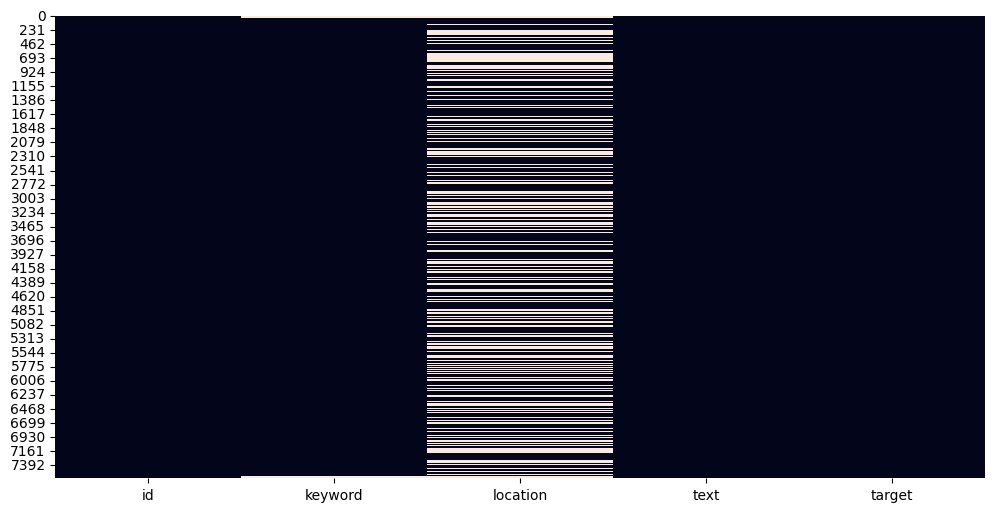

In [43]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isna(), cbar=False)

In [44]:
nb_uniques = df["keyword"].nunique()  # nombre de mots-clés uniques (≠ valeurs nulles)
nb_non_nulls = df["keyword"].notnull().sum()  # cellules non vides
pourcentage_remplis = nb_non_nulls / len(df) * 100

print("Nombre de mots clés uniques :", nb_uniques)
print(f"Pourcentage de cellules remplies : {pourcentage_remplis:.2f}%")


Nombre de mots clés uniques : 221
Pourcentage de cellules remplies : 99.20%


In [45]:
nb_uniques = df["location"].nunique()
nb_non_nulls = df["location"].notnull().sum()
pourcentage_remplis = nb_non_nulls / len(df) * 100


print("Nombre de mots location uniques :", nb_uniques)
print(f"Pourcentage de cellules remplies : {pourcentage_remplis:.2f}%")


Nombre de mots location uniques : 3341
Pourcentage de cellules remplies : 66.73%


In [46]:
duplicate = df.duplicated().sum()  # nombre de doublons
print(f"Doublons :", duplicate)

Doublons : 0


In [47]:
df.drop_duplicates(inplace=True)  # suppression des doublons
print(f"Doublons après suppression :", df.duplicated().sum())

Doublons après suppression : 0


In [48]:
df = df.drop("id", axis=1)


In [49]:
print(df.shape)

(7613, 4)


In [50]:
df['target'].value_counts(normalize=True) * 100

target
0    57.034021
1    42.965979
Name: proportion, dtype: float64

In [51]:
df_negative = df[df['target'] == 0]
df_positive = df[df['target'] == 1]

## Ajout features

In [52]:
# Nombre total de mots dans chaque tweet
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Nombre de mots uniques dans chaque tweet
df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))

# Nombre de stopwords (mots vides comme 'le', 'et', 'mais'...) dans chaque tweet
df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# Nombre de liens URL présents dans chaque tweet
df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# Longueur moyenne des mots dans chaque tweet
df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# Nombre total de caractères (lettres, espaces, ponctuations...) dans chaque tweet
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

# Nombre de signes de ponctuation dans chaque tweet
df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Nombre de hashtags (#) dans chaque tweet
df['hashtag_count'] = df['text'].apply(lambda x: str(x).count('#'))

# Nombre de mentions (@) dans chaque tweet
df['mention_count'] = df['text'].apply(lambda x: str(x).count('@'))

#Si location est présente, on marque 1, sinon 0
df['presence_location'] = df['location'].notnull().astype(int)

#Si keyword est présent, on marque 1, sinon 0
df['presence_keyword'] = df['keyword'].notnull().astype(int)


In [53]:
df.dtypes.value_counts()

int64      11
object      3
float64     1
Name: count, dtype: int64

In [54]:
df_negative = df[df['target'] == 0]
df_positive = df[df['target'] == 1]

In [55]:
# Sélection des colonnes numériques
num_cols = df.select_dtypes(include='number').columns
# Calcul des stats descriptives
desc_all = df[num_cols].describe().T
desc_neg = df_negative[num_cols].describe().T
desc_pos = df_positive[num_cols].describe().T

# Renommage des colonnes pour préciser l’origine
desc_all.columns = [f"{col}_all" for col in desc_all.columns]
desc_neg.columns = [f"{col}_neg" for col in desc_neg.columns]
desc_pos.columns = [f"{col}_pos" for col in desc_pos.columns]

# Fusion sur l'index (nom des colonnes numériques)
summary = desc_all.join(desc_neg).join(desc_pos)

# Réorganisation (optionnelle) des colonnes
ordered_cols = []
for stat in ["count", "mean", "50%", "25%", "75%"]:
    ordered_cols.extend([
        f"{stat}_all", f"{stat}_neg", f"{stat}_pos"
    ])

# Affichage
summary[ordered_cols]

,count_all,count_neg,count_pos,mean_all,mean_neg,mean_pos,50%_all,50%_neg,50%_pos,25%_all,25%_neg,25%_pos,75%_all,75%_neg,75%_pos
target,7613.0,4342.0,3271.0,0.429660,0.000000,1.000000,0.000000,0.000000,1.000000,0.000,0.0,1.00000,1.000000,0.000000,1.0000
word_count,7613.0,4342.0,3271.0,14.903586,14.704744,15.167533,15.000000,15.000000,15.000000,11.000,10.0,11.00000,19.000000,19.000000,19.0000
unique_word_count,7613.0,4342.0,3271.0,14.340733,14.096499,14.664934,14.000000,14.000000,15.000000,11.000,10.0,11.00000,18.000000,18.000000,18.0000
stop_word_count,7613.0,4342.0,3271.0,4.672928,5.016582,4.216753,4.000000,4.000000,3.000000,2.000,2.0,2.00000,7.000000,7.000000,6.0000
url_count,7613.0,4342.0,3271.0,0.620255,0.507600,0.769795,1.000000,0.000000,1.000000,0.000,0.0,0.00000,1.000000,1.000000,1.0000
mean_word_length,7613.0,4342.0,3271.0,6.128494,5.871325,6.469866,5.928571,5.538462,6.352941,4.875,4.6,5.47619,7.058824,6.818182,7.3125
char_count,7613.0,4342.0,3271.0,101.037436,95.706817,108.113421,107.000000,101.000000,115.000000,78.000,68.0,88.00000,133.000000,130.000000,136.0000
punctuation_count,7613.0,4342.0,3271.0,6.839485,6.309074,7.543565,6.000000,6.000000,7.000000,3.000,3.0,5.00000,10.000000,9.000000,10.0000
hashtag_count,7613.0,4342.0,3271.0,0.446999,0.391525,0.520636,0.000000,0.000000,0.000000,0.000,0.0,0.00000,0.000000,0.000000,1.0000
mention_count,7613.0,4342.0,3271.0,0.362406,0.426992,0.276674,0.000000,0.000000,0.000000,0.000,0.0,0.00000,1.000000,1.000000,0.0000


In [ ]:
DISASTER_TWEETS = df['target'] == 1

# Création de la figure avec sous-graphiques
fig, axes = plt.subplots(nrows=len(df[num_cols]), ncols=1, figsize=(12, 40), dpi=100)

# Pour chaque feature, on trace deux courbes : disaster vs non-disaster
for i, feature in enumerate(df[num_cols]):
    sns.histplot(data=df, x=feature, hue='target', kde=True, ax=axes[i], bins=30,
                 palette={0: "green", 1: "red"}, element="step", stat="density")
    
    axes[i].set_title(f'Distribution of {feature} by Target', fontsize=13)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

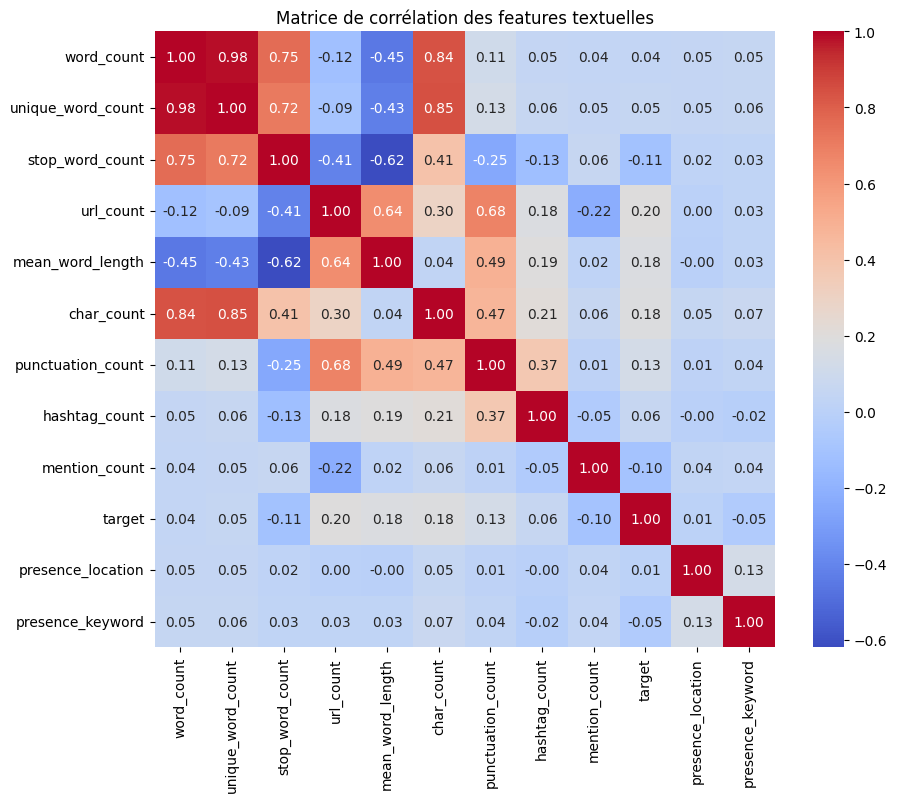

In [ ]:
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation des features textuelles")
plt.show()

In [59]:
# Fonction pour obtenir les mots les plus fréquents
def get_top_words(series, n=10):
    words = " ".join(series.fillna("").astype(str)).lower().split()
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return Counter(words).most_common(n)



# Extraction des top mots
top_words_0 = get_top_words(df_negative["keyword"], 10)
top_words_1 = get_top_words(df_positive["keyword"], 10)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Keyword (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Keyword (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Keyword (Non-catastrophe),Fréquence,Keyword (Catastrophe),Fréquence
0,body%20bags,40,derailment,39
1,armageddon,37,outbreak,39
2,harm,37,wreckage,39
3,deluge,36,debris,37
4,ruin,36,oil%20spill,37
5,wrecked,36,typhoon,37
6,explode,35,evacuated,32
7,fear,35,rescuers,32
8,siren,35,suicide%20bomb,32
9,twister,35,suicide%20bombing,32


In [60]:
# Extraction des top mots
top_words_0 = get_top_words(df_negative["location"], 10)
top_words_1 = get_top_words(df_positive["location"], 10)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Location (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Location (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Location (Non-catastrophe),Fréquence,Location (Catastrophe),Fréquence
0,new,129,usa,126
1,usa,124,new,80
2,ca,86,ca,57
3,york,77,united,44
4,london,52,nigeria,42
5,united,51,canada,41
6,uk,49,uk,40
7,ny,46,india,34
8,england,44,san,33
9,canada,43,states,33


In [61]:
# Extraction des top mots
top_words_0 = get_top_words(df_negative["text"], 10)
top_words_1 = get_top_words(df_positive["text"], 10)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Mot (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Mot (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Mot (Non-catastrophe),Fréquence,Mot (Catastrophe),Fréquence
0,-,374,-,389
1,like,250,...,106
2,just,229,&amp;,105
3,i'm,195,suicide,103
4,&amp;,190,disaster,97
5,??,183,police,94
6,new,163,people,93
7,it's,124,killed,92
8,don't,122,like,91
9,body,106,california,88


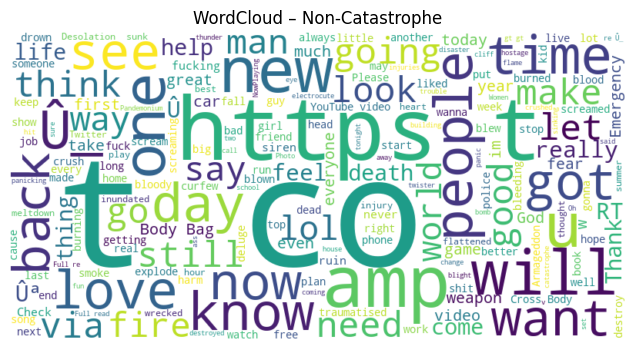

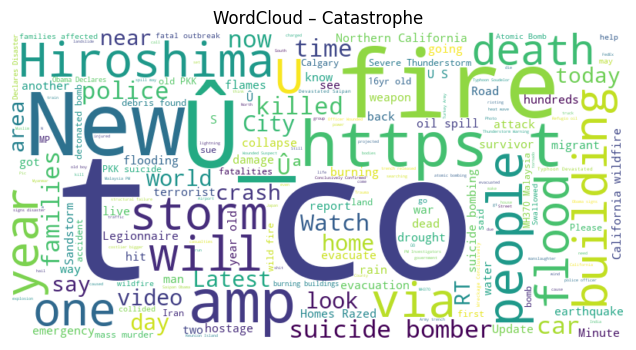

In [62]:
# Concaténer les textes par classe
text_0 = " ".join(df_negative["text"])
text_1 = " ".join(df_positive["text"])

# Générer les nuages de mots
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Affichage du WordCloud pour target = 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Affichage du WordCloud pour target = 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()

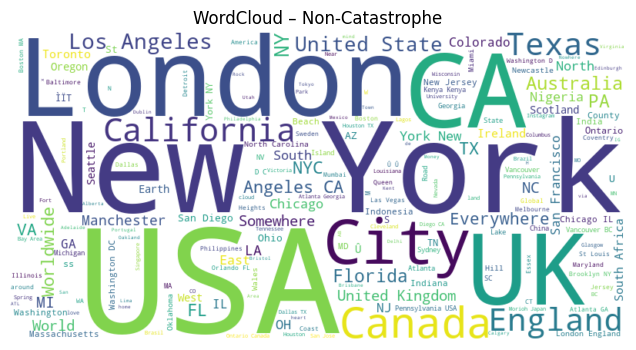

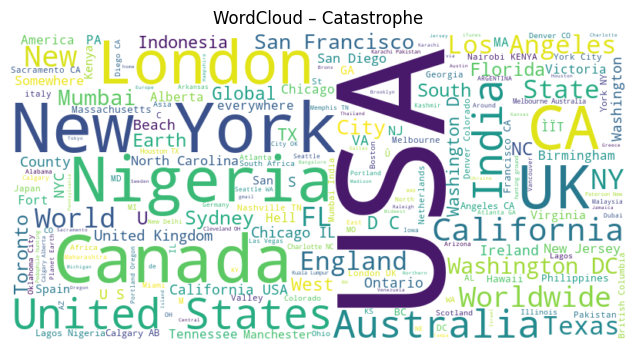

In [63]:
# Concaténer les textes par classe
text_0 = " ".join(df_negative["location"].dropna())
text_1 = " ".join(df_positive["location"].dropna())


# Générer les nuages de mots
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Affichage du WordCloud pour target = 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Affichage du WordCloud pour target = 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()
